In [1]:
import pathlib
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as ar
import matplotlib.pyplot as pl

%matplotlib inline

In [26]:
ar.style.use('arviz-darkgrid')

In [2]:
home_dir = pathlib.Path.home()

In [3]:
data_path = home_dir / 'PROJECTS/BAYES/Bayesian-Analysis-with-Python-Second-Edition-master'

In [6]:
data_path.exists()

True

In [15]:
islands_dist_path = data_path / 'data/islands_dist.csv'
islands_path = data_path / 'data/islands.csv'

In [10]:
d_isl_dist = pd.read_csv(islands_dist_path, index_col=0)

In [14]:
d_isl_dist.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


In [16]:
d_isl = pd.read_csv(islands_path)

In [19]:
d_isl.round(1)

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.0
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.3
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.2
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.5
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.9
5,Trobriand,8000,high,19,4.0,-8.7,150.9,-29.1,9.0
6,Chuuk,9200,high,40,3.8,7.4,151.6,-28.4,9.1
7,Manus,13000,low,28,6.6,-2.1,146.9,-33.1,9.5
8,Tonga,17500,high,55,5.4,-21.2,-175.2,4.8,9.8
9,Hawaii,275000,low,71,6.6,19.9,-155.6,24.4,12.5


In [18]:
isl_dist_sqr = d_isl_dist.values **2
culture_labels = d_isl.culture.values
index = d_isl.index.values
log_pop = d_isl.logpop
tot_tools = d_isl.total_tools
x_data =[d_isl.lat.values[:, None], d_isl.lon.values[:, None]]

Model to be built ( with priors on $\alpha$, $\beta$, and $K$'s hyperpriors omitted:
$$f\sim \mathcal{GP}([0, ..., 0], K(x, x'))$$
    $$\mu \sim exp(\alpha + \beta x + f)$$
        $$ y \sim Poisson(\mu)$$

In [21]:
with pm.Model() as m_isl:
    η = pm.HalfCauchy('η', 1)
    ℓ = pm.HalfCauchy('ℓ', 1)
    
    cov = η * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=isl_dist_sqr)
    
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + β*log_pop + f[index])
    tt_pred = pm.Poisson('tt_pred', μ, observed=tot_tools)
    trace_islands = pm.sample(1000, tune=1000)
                  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α, f_rotated_, ℓ, η]
Sampling 4 chains: 100%|██████████| 8000/8000 [06:18<00:00, 21.11draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


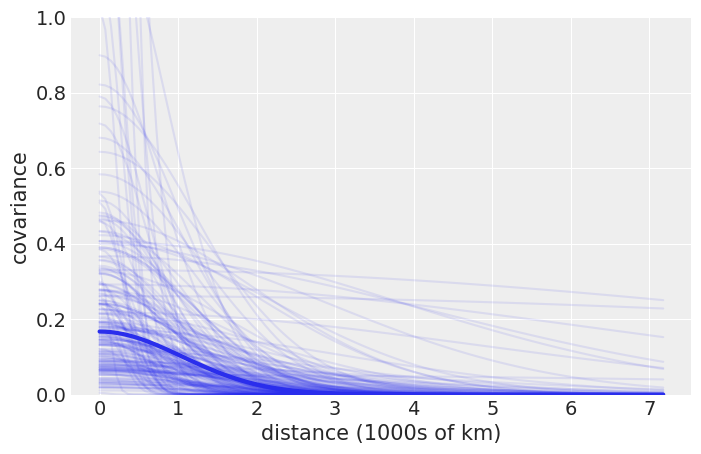

In [34]:
trace_η = trace_islands['η']
trace_ℓ = trace_islands['ℓ']
_, ax = pl.subplots(figsize=(8, 5))
xrange = np.linspace(0, d_isl_dist.values.max(), 100)
ax.plot(xrange, np.median(trace_η) * 
        np.exp(-np.median(trace_ℓ) * xrange ** 2), lw=3)
ax.plot(xrange, (trace_η[::20][:, None] * 
                 np.exp(-trace_ℓ[::20][:, None] * xrange**2)).T,
       'C0', alpha=.1)
ax.set_ylim(0, 1)
ax.set_xlabel('distance (1000s of km)')
ax.set_ylabel('covariance');

In [36]:
# compute posterior meidan covariance among societies
Σ = np.median(trace_η) * np.exp(-np.median(trace_ℓ) * isl_dist_sqr)
# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ)**-0.5)
ρ = Σ_post @ Σ @ Σ_post
ρ = pd.DataFrame(ρ, index=d_isl_dist.columns, columns=d_isl_dist.columns)
ρ.round(2)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Ml,1.00,0.90,0.83,0.00,0.50,0.15,0.01,0.03,0.21,0.0
Ti,0.90,1.00,0.96,0.00,0.50,0.16,0.02,0.04,0.17,0.0
SC,0.83,0.96,1.00,0.00,0.33,0.26,0.05,0.08,0.09,0.0
Ya,0.00,0.00,0.00,1.00,0.00,0.06,0.33,0.30,0.00,0.0
Fi,0.50,0.50,0.33,0.00,1.00,0.01,0.00,0.00,0.77,0.0
Tr,0.15,0.16,0.26,0.06,0.01,1.00,0.23,0.72,0.00,0.0
Ch,0.01,0.02,0.05,0.33,0.00,0.23,1.00,0.51,0.00,0.0
Mn,0.03,0.04,0.08,0.30,0.00,0.72,0.51,1.00,0.00,0.0
To,0.21,0.17,0.09,0.00,0.77,0.00,0.00,0.00,1.00,0.0
Ha,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
